# Yolov6 Pytorch
This notebook shows how to compile Yolov6/Pytorch to AWS Inferentia (inf1 instances) using NeuronSDK.

**Reference:** https://github.com/meituan/YOLOv6.git

## 1) Install dependencies

Verify that this Jupyter notebook is running the Python kernel environment that was set up according to the [Inf1 PyTorch Installation Guide](https://awsdocs-neuron.readthedocs-hosted.com/en/latest/general/setup/torch-neuron.html#setup-torch-neuron). You can select the kernel from the 'Kernel -> Change Kernel' option on the top of this Jupyter notebook page.

In [ ]:
#Install Neuron PyTorch
%pip install -U torch-neuron "protobuf<4" numpy==1.21.6 torchvision PyYAML tensorflow==1.15.3
# use --force-reinstall if you're facing some issues while loading the modules
# now restart the kernel again

### 1.1) Create a patch to fix an issue related to casting
We need to apply a patch to fix an error during compilation, when you add(int32 + float32) is invoked. This fix explicitly casts the tensor before the op.

In [ ]:
%%writefile fp32fix.patch
diff --git a/yolov6/assigners/anchor_generator.py b/yolov6/assigners/anchor_generator.py
index 3704620..6937471 100644
--- a/yolov6/assigners/anchor_generator.py
+++ b/yolov6/assigners/anchor_generator.py
@@ -11,15 +11,15 @@ def generate_anchors(feats, fpn_strides, grid_cell_size=5.0, grid_cell_offset=0.
     if is_eval:
         for i, stride in enumerate(fpn_strides):
             _, _, h, w = feats[i].shape
-            shift_x = torch.arange(end=w, device=device) + grid_cell_offset
-            shift_y = torch.arange(end=h, device=device) + grid_cell_offset
+            shift_x = torch.arange(end=w, device=device, dtype=torch.float32) + grid_cell_offset
+            shift_y = torch.arange(end=h, device=device, dtype=torch.float32) + grid_cell_offset
             shift_y, shift_x = torch.meshgrid(shift_y, shift_x)
             anchor_point = torch.stack(
-                    [shift_x, shift_y], axis=-1).to(torch.float)
+                    [shift_x, shift_y], axis=-1).to(torch.float32)
             anchor_points.append(anchor_point.reshape([-1, 2]))
             stride_tensor.append(
                 torch.full(
-                    (h * w, 1), stride, dtype=torch.float, device=device))
+                    (h * w, 1), stride, dtype=torch.float32, device=device))
         anchor_points = torch.cat(anchor_points)
         stride_tensor = torch.cat(stride_tensor)
         return anchor_points, stride_tensor

### 1.2) Clone the official YoloV6 repo
We'll use release **0.2.0**

In [ ]:
import os

tag='0.2.0'
if not os.path.isdir('YOLOv6'):
    !git clone -b $tag https://github.com/meituan/YOLOv6.git
    !cd YOLOv6 && git apply ../fp32fix.patch

## 2) Initialize libraries and prepare input samples

In [ ]:
import os
import urllib
import sys
if not 'YOLOv6' in sys.path: sys.path.insert(0, 'YOLOv6')
    
from yolov6.models.yolo import *
from yolov6.models.effidehead import Detect
from yolov6.layers.common import *
from yolov6.utils.events import LOGGER
from yolov6.utils.checkpoint import load_checkpoint
from io import BytesIO
import torch
import torch.neuron

model_type='l'
assert(model_type in ['n', 's', 'm', 'l'])

# Download a pre-trained model from:
# https://github.com/meituan/YOLOv6/releases/tag/<TAG>
model_name=f'yolov6{model_type}.pt'
model_url=f'https://github.com/meituan/YOLOv6/releases/download/{tag}/{model_name}'
if not os.path.isfile(model_name):
    urllib.request.urlretrieve(model_url, model_name)

x = torch.rand([1, 3, 640, 640], dtype=torch.float32)

## 3) Load a pre-trained model and check if it is .jit traceable

In [ ]:
import types
model = load_checkpoint(model_name, map_location='cpu', inplace=True, fuse=True)
model.eval()

# we need to replace the forward method to make it traceable
if not hasattr(model, 'forward_'): model.forward_ = model.forward
model.forward = types.MethodType(lambda self,x: self.detect(self.neck(self.backbone(x))), model)

y = model(x) # warmup
try:
    traced = torch.jit.trace(model, x)
    print("Cool! Model is jit traceable")
except Exception as e:
    print("Ops. Something went wrong. Model is not traceable")

## ok the model is .jit traceable. now let's compile it with NeuronSDK

## 4) Analyze & compile the model for Inferentia with NeuronSDK

Neuron Check Model tool provides user with basic information about the compiled and uncompiled model’s operations without the use of TensorBoard-Neuron.  
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-tools/tutorial-neuron-check-model.html


The PyTorch-Neuron trace Python API provides a method to generate PyTorch models for execution on Inferentia, which can be serialized as TorchScript. It is analogous to torch.jit.trace() function in PyTorch.   
https://awsdocs-neuron.readthedocs-hosted.com/en/latest/neuron-guide/neuron-frameworks/pytorch-neuron/api-compilation-python-api.html?highlight=trace

In [ ]:
import torch
import torch.neuron
torch.neuron.analyze_model(model, example_inputs=x)

In [ ]:
import torch
import torch.neuron
model_neuron = torch.neuron.trace(model, example_inputs=x)

## Export to saved model
model_neuron.save("yolov6_neuron.pt")

### 4.1) Verify the optimized model

In [ ]:
y = model_neuron(x)
%timeit model_neuron(x)

## 5) A simple test to check the predictions

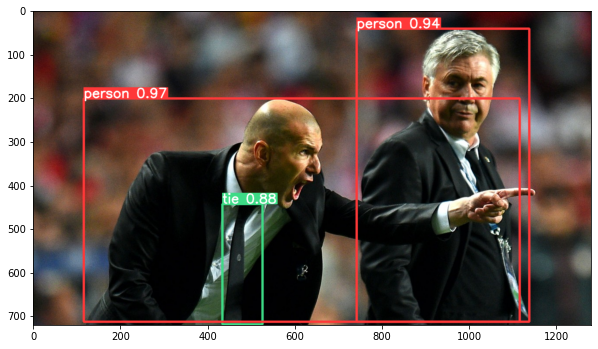

In [2]:
%matplotlib inline
import os
import sys
import cv2
import torch
import torch.neuron
import urllib
import matplotlib.pyplot as plt

if not 'YOLOv6' in sys.path: sys.path.insert(0, 'YOLOv6')

from yolov6.utils.events import LOGGER, load_yaml
from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression
from yolov6.core.inferer import Inferer

if not '..' in sys.path: sys.path.append('..')

from common import processing

conf_thres =.30
iou_thres =.45
max_det =  1000
agnostic_nms = False
classes = None # the classes to keep
hide_labels = False
hide_conf = False

model_neuron = torch.load('yolov6_neuron.pt')
class_names = load_yaml("YOLOv6/data/coco.yaml")['names']

img = processing.load_sample_imgB()

x = processing.preprocess_coco(img,disable_letterbox=True)
x = torch.from_numpy(x)

pred_results = model_neuron(x)

det = non_max_suppression(pred_results, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)[0]
img_ori = img.copy()
if len(det):
    det[:, :4] = Inferer.rescale(x.shape[2:], det[:, :4], img.shape).round()
    for *xyxy, conf, cls in reversed(det):
        class_num = int(cls)
        label = None if hide_labels else (class_names[class_num] if hide_conf else f'{class_names[class_num]} {conf:.2f}')
        Inferer.plot_box_and_label(img_ori, max(round(sum(img_ori.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True))
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(img_ori, cv2.COLOR_BGR2RGB))